## Setting up the environment
```
conda create -n fba-env -c conda-forge python=3.11 cobra glpk ipykernel pandas matplotlib -y
conda activate fba-env
python -m ipykernel install --user --name fba-env --display-name "Python (fba-env)"
```
Then set the notebook kernel to **Python (fba-env)**.

#### Before we optimize the model, we need to make sure the “We have right version and tools!”

In [35]:
# 1) Check the installation of packages and solver
import sys
print("Python:", sys.version)
try:
    import cobra, optlang
    print("COBRApy:", cobra.__version__)
    print("optlang:", optlang.__version__)
    from cobra.util.solver import linear_reaction_coefficients
    # solver report
    from cobra.util.solver import get_solver_name
    print("Solver backend:", get_solver_name())
except Exception as e:
    print("Problem loading cobra/optlang:", e)
    raise

Python: 3.11.9 (main, Apr 19 2024, 11:43:47) [Clang 14.0.6 ]
COBRApy: 0.29.0
optlang: 1.8.3
Solver backend: glpk


## 2) Load the E. coli nuclear model (textbook model)
COBRApy has a ready-made small model of E. coli metabolic pathways.

Why is it called textbook?
Because this model is not written for professional research.
More realistic E. coli models have thousands of reactions, 
but the textbook model has only 95 reactions to teach basic concepts like FBA, FVA, and knockout.

In [53]:
from cobra.io import load_model

model = load_model("textbook")
model


Name,e_coli_core
Memory address,174bb6350
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


### Model inspection
There are usually three basic questions that are always asked:
1. How many reactions does it have?
2. How many metabolites does it have?
3. How many genes are associated with it?
Because these three numbers give you a sense of the scale and complexity of the model.

In [7]:
len(model.reactions), len(model.metabolites), len(model.genes)


(95, 72, 137)

What are you looking for, and do you want to increase or decrease it?"
And the model replies:
I want to increase growth. (Max)

In [62]:
model.objective, model.objective.direction

(<optlang.glpk_interface.Objective at 0x174c93a10>, 'max')

In [64]:
for r in list(model.reactions)[:8]:
    print(r.id, ":", r.reaction)

ACALD : acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c
ACALDt : acald_e <=> acald_c
ACKr : ac_c + atp_c <=> actp_c + adp_c
ACONTa : cit_c <=> acon_C_c + h2o_c
ACONTb : acon_C_c + h2o_c <=> icit_c
ACt2r : ac_e + h_e <=> ac_c + h_c
ADK1 : amp_c + atp_c <=> 2.0 adp_c
AKGDH : akg_c + coa_c + nad_c --> co2_c + nadh_c + succoa_c


### Implementing FBA (Optimizing for Growth)
This step is to solve the optimization problem of the metabolic model.
From a biological perspective, it gives the growth rate and the main fluxes of the pathways.
From a Data Science perspective, this output is the results of the linear mathematical model that you can later analyze.

In [13]:
solution = model.optimize()
print("Status:", solution.status)
print("Growth (1/h):", round(solution.objective_value, 5))
flux_series = solution.fluxes.sort_values(ascending=False)
flux_series.head(10)

Status: optimal
Growth (1/h): 0.87392


ATPS4r      45.514010
CYTBD       43.598985
NADH16      38.534610
EX_h2o_e    29.175827
EX_co2_e    22.809833
O2t         21.799493
EX_h_e      17.530865
GAPD        16.023526
ENO         14.716140
GLCpts      10.000000
Name: fluxes, dtype: float64

### Medium manipulation and its effect on growth
In FBA, changing the exchange bounds = simulating a change in the environment.
And the output objective_value is like a measure of the "health" or "growth potential" of the cell.
That is, how well the cell performs under different conditions, just like evaluating the performance of a machine learning model on different inputs.

In [80]:
# Example: Glucose and oxygen bound
import contextlib

def set_bound(rx_id, lb=None, ub=None):
    rx = model.reactions.get_by_id(rx_id)
    if lb is not None: rx.lower_bound = lb
    if ub is not None: rx.upper_bound = ub

# Save default values to return later
defaults = {r.id: (r.lower_bound, r.upper_bound) for r in model.reactions}

with model:  # Temperary change
    # Common exchange reactions in this model:
    # EX_glc__D_e  (Glucose)، EX_o2_e (O2)
    set_bound("EX_glc__D_e", lb=-10)  # Glucose uptake (- means uptake)
    set_bound("EX_o2_e", lb=-20)      # Oxygen uptake
    sol = model.optimize()
    print("Growth with glucose/oxygen uptake:", round(sol.objective_value,5))

with model:
    set_bound("EX_glc__D_e", lb=0)    # without Glucose
    set_bound("EX_o2_e", lb=-20)
    sol = model.optimize()
    print("Growth without glucose:", round(sol.objective_value,5))

with model:
    set_bound("EX_glc__D_e", lb=-10)
    set_bound("EX_o2_e", lb=0)        # without oxugen
    sol = model.optimize()
    print("Growth without oxygen:", round(sol.objective_value,5))

Growth with glucose/oxygen uptake: 0.83261
Growth without glucose: 0.0
Growth without oxygen: 0.21166


/opt/anaconda3/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


### FVA

In [83]:
# A resistant version called Biomass
from cobra.flux_analysis import flux_variability_analysis
from cobra.util.solver import linear_reaction_coefficients
import pandas as pd

# Extract the exact ID of the target reaction(s) from the model
obj_coefs = linear_reaction_coefficients(model)
biomass_ids = [r.id for r, c in obj_coefs.items() if abs(c) > 0]

# If for any reason nothing is found, do an helping search.
if not biomass_ids:
    biomass_ids = [r.id for r in model.reactions if "biomass" in r.id.lower()]

print("Biomass reaction(s):", biomass_ids)

# Subset of reactions for FVA: All exchanges + biomass
subset = [r.id for r in model.reactions if r.id.startswith("EX_")] + biomass_ids

# Implementing FVA (at 100% of optimal growth)
fva_df = flux_variability_analysis(model, reaction_list=subset, fraction_of_optimum=1.0)

# Sort by range of change (max and min range)
fva_df = fva_df.assign(span=(fva_df["maximum"] - fva_df["minimum"]).abs())
fva_df = fva_df.sort_values("span", ascending=False)

fva_df.head(12)

Biomass reaction(s): ['Biomass_Ecoli_core']


,minimum,maximum,span
EX_h_e,17.530865,1.753087e+01,1.243450e-13
EX_co2_e,22.809833,2.280983e+01,4.973799e-14
EX_for_e,0.000000,-4.112009e-14,4.112009e-14
EX_glu__L_e,0.000000,-2.937405e-14,2.937405e-14
EX_ac_e,0.000000,2.546480e-14,2.546480e-14
EX_acald_e,0.000000,-1.617902e-14,1.617902e-14
EX_pi_e,-3.214895,-3.214895e+00,1.509903e-14
EX_pyr_e,0.000000,-1.480991e-14,1.480991e-14
EX_h2o_e,29.175827,2.917583e+01,1.421085e-14
EX_etoh_e,0.000000,-1.235548e-14,1.235548e-14


### Eliminate reaction and observation
Turn off the PFK gene:
Without this enzyme, E. coli cannot survive.

In [21]:
def knockout_reaction(model, rx_id):
    rx = model.reactions.get_by_id(rx_id)
    old_lb, old_ub = rx.lower_bound, rx.upper_bound
    rx.lower_bound = 0.0
    rx.upper_bound = 0.0
    return (rx, old_lb, old_ub)

with model:
    rx, lb, ub = knockout_reaction(model, "PFK")  # فسفوفروکتوکیناز در گلیکولیز
    sol = model.optimize()
    print("Growth after PFK knockout:", round(sol.objective_value,5))


Growth after PFK knockout: 0.70404


### Sampling
In regular FBA you only see the “best state of cell life”, but with Sampling you are discovering the “full spectrum of cell life states”.

In [87]:
from cobra.sampling import sample

# Keep the number of samples small to finish quickly; for better results, make n larger.
samples = sample(model, n=200, method="achr")  # DataFrame fluxes
samples.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
ACALD,200.0,-1.971226,1.254370,-5.247142,-2.653086,-1.786460,-0.995849,-0.045314
ACALDt,200.0,-1.024606,0.956005,-4.196548,-1.438415,-0.704837,-0.281215,-0.002181
ACKr,200.0,-1.339490,1.182624,-5.651699,-1.870436,-1.003729,-0.364748,-0.004582
ACONTa,200.0,8.665403,2.606268,2.131127,6.886131,8.680711,10.761978,15.798855
ACONTb,200.0,8.665403,2.606268,2.131127,6.886131,8.680711,10.761978,15.798855
ACt2r,200.0,-1.339490,1.182624,-5.651699,-1.870436,-1.003729,-0.364748,-0.004582
ADK1,200.0,13.030272,9.187194,0.213258,5.910869,11.103157,17.800831,44.638227
AKGDH,200.0,3.330850,2.416822,0.011015,1.479530,2.824279,4.899792,10.905636
AKGt2r,200.0,-0.519007,0.496890,-2.446259,-0.744871,-0.342325,-0.151275,-0.002121
ALCD2x,200.0,-0.946621,0.880613,-4.060119,-1.325966,-0.668473,-0.266956,-0.014509


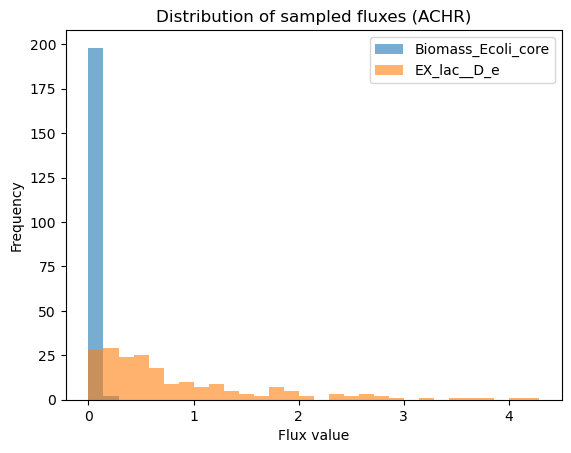

In [127]:
import matplotlib.pyplot as plt
cols = [c for c in samples.columns if c in ("EX_lac__D_e", "Biomass_Ecoli_core")]
#cols = [c for c in samples.columns if c in ("EX_lac__D_e", "Biomass_Ecoli_core_w_GAM")]
ax = samples[cols].plot(kind="hist", bins=30, alpha=0.6)
ax.set_title("Distribution of sampled fluxes (ACHR)")
ax.set_xlabel("Flux value")
plt.savefig("results/image_4_Distribution.png", dpi=300, bbox_inches="tight")
plt.show()

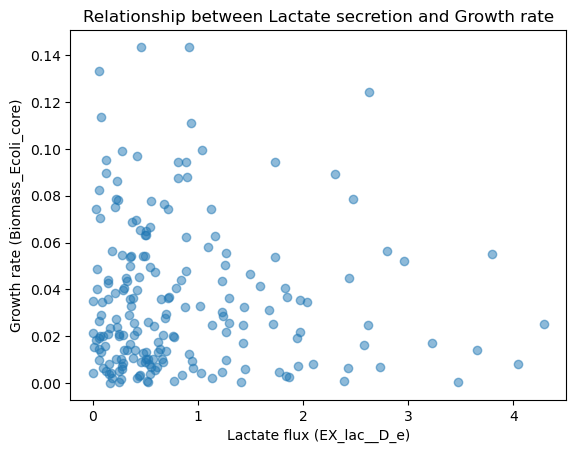

In [97]:
import matplotlib.pyplot as plt

plt.scatter(samples["EX_lac__D_e"], samples["Biomass_Ecoli_core"], alpha=0.5)
plt.xlabel("Lactate flux (EX_lac__D_e)")
plt.ylabel("Growth rate (Biomass_Ecoli_core)")
plt.title("Relationship between Lactate secretion and Growth rate")
plt.show()

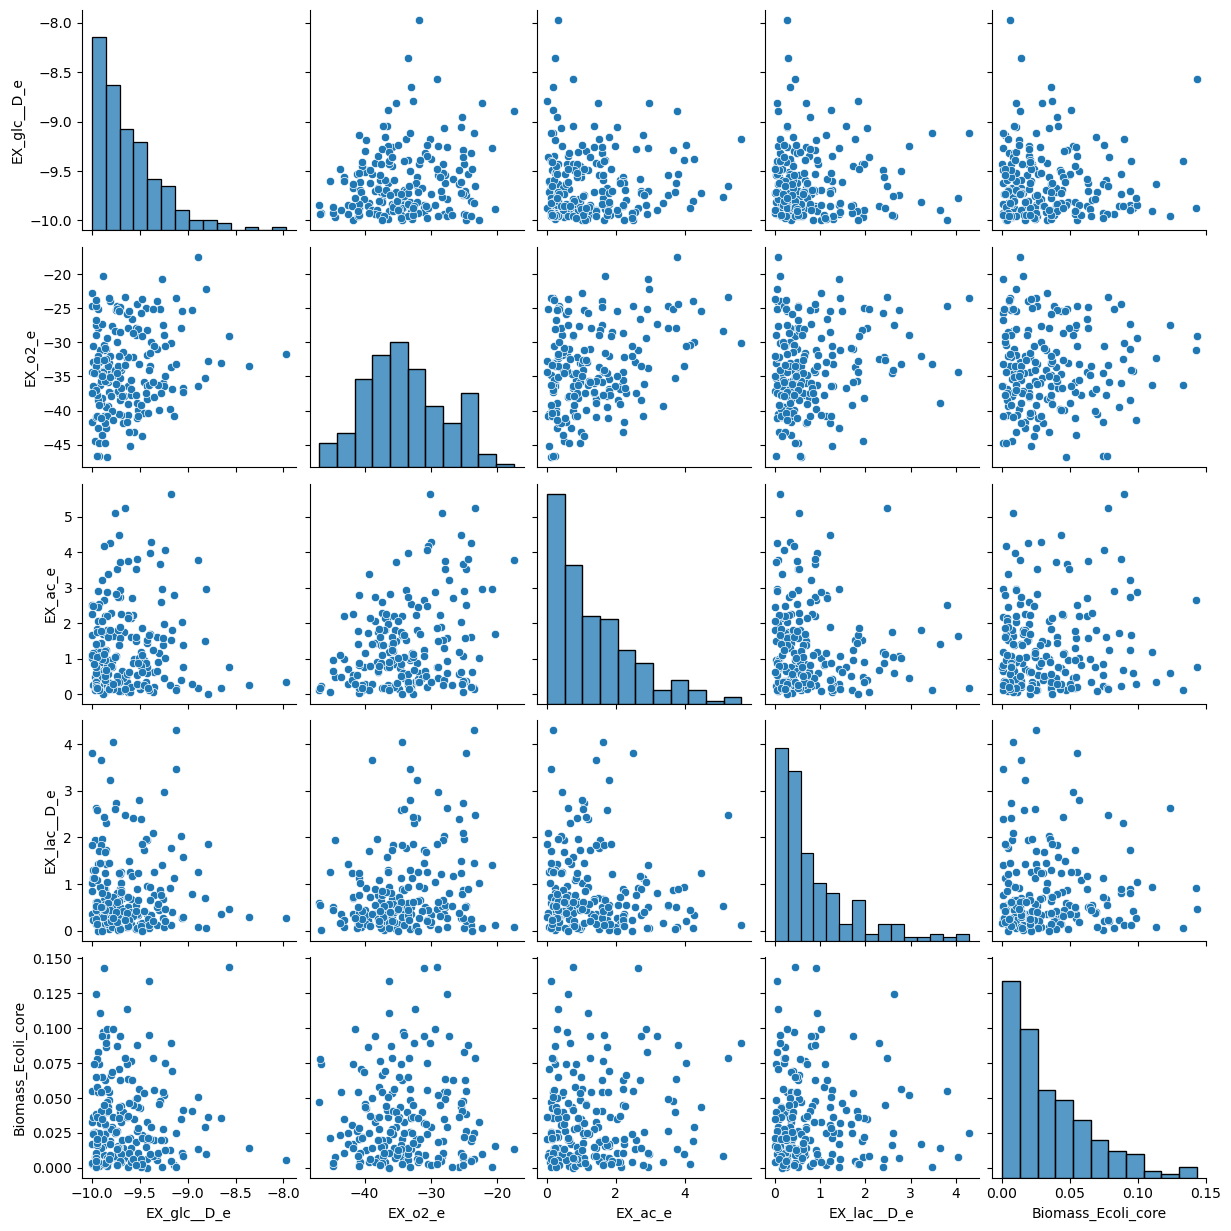

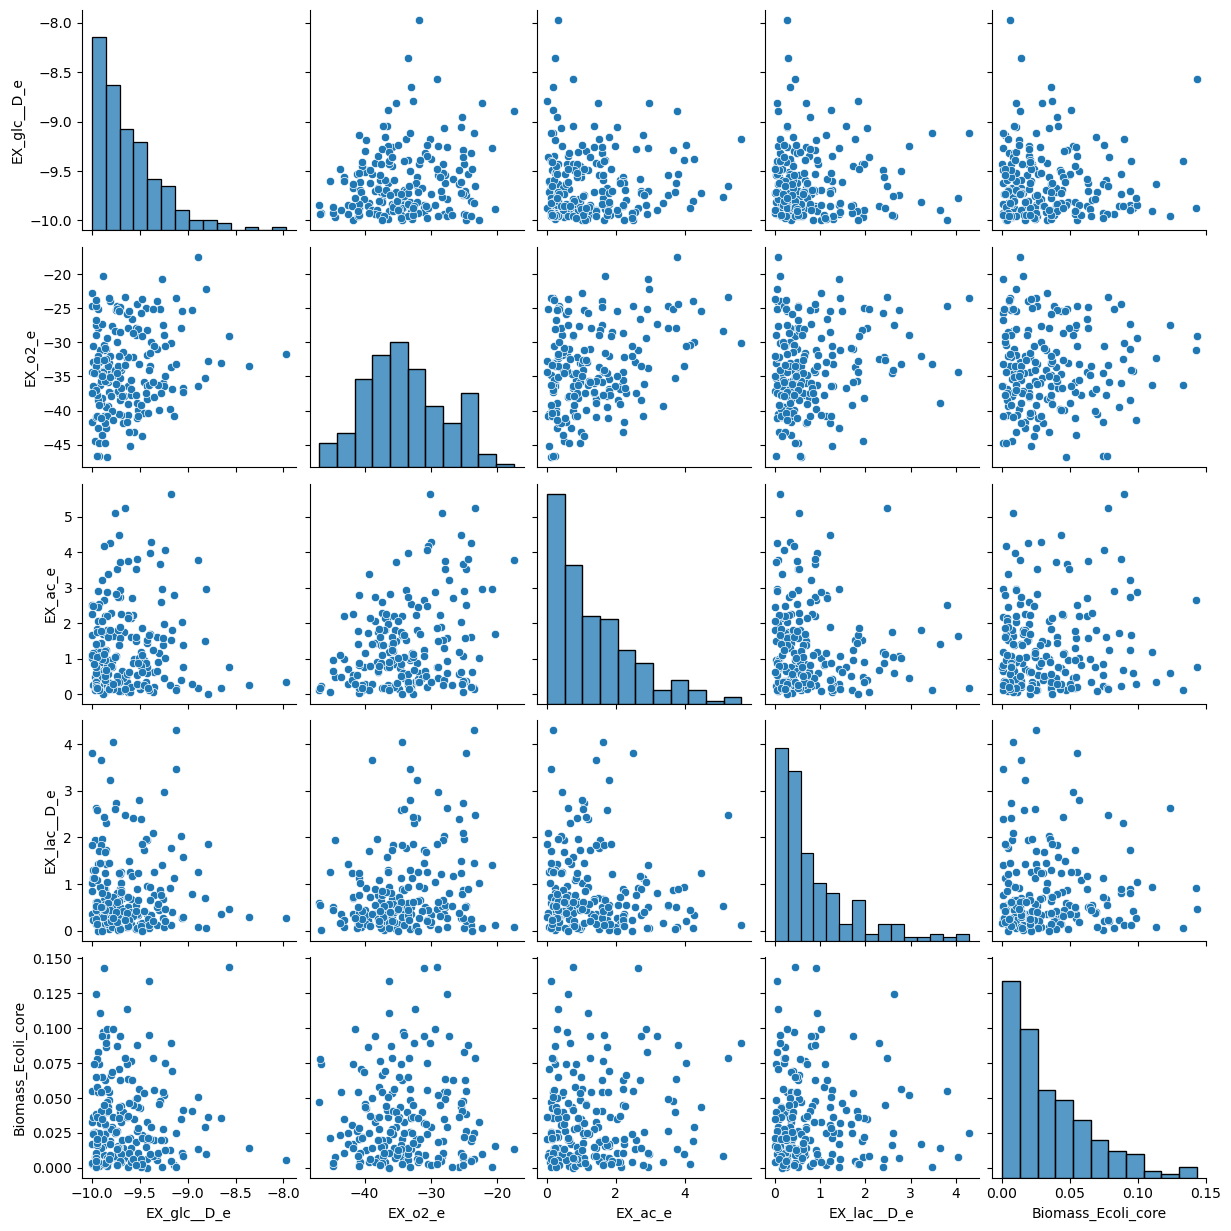

In [123]:
import seaborn as sns
important = samples[["EX_glc__D_e", "EX_o2_e", "EX_ac_e", "EX_lac__D_e", "Biomass_Ecoli_core"]]
sns.pairplot(important)
plot = sns.pairplot(samples[["EX_glc__D_e", "EX_o2_e", "EX_ac_e", "EX_lac__D_e", "Biomass_Ecoli_core"]])
plot.savefig("results/image_3_Pairplot.png", dpi=300)

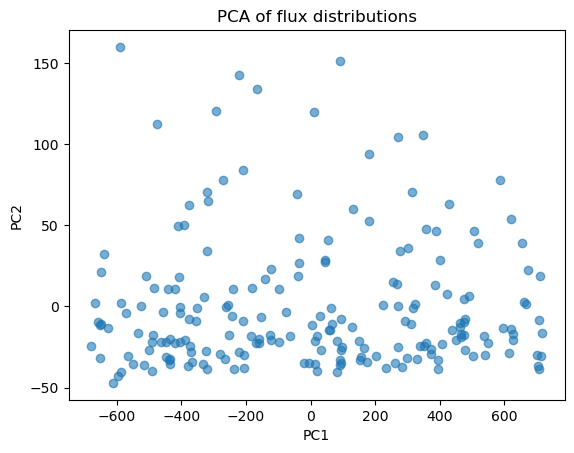

In [117]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
flux_pca = pca.fit_transform(samples)
plt.scatter(flux_pca[:,0], flux_pca[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of flux distributions")
plt.savefig("results/image_2_PCA.png", dpi=300, bbox_inches="tight")
plt.show()

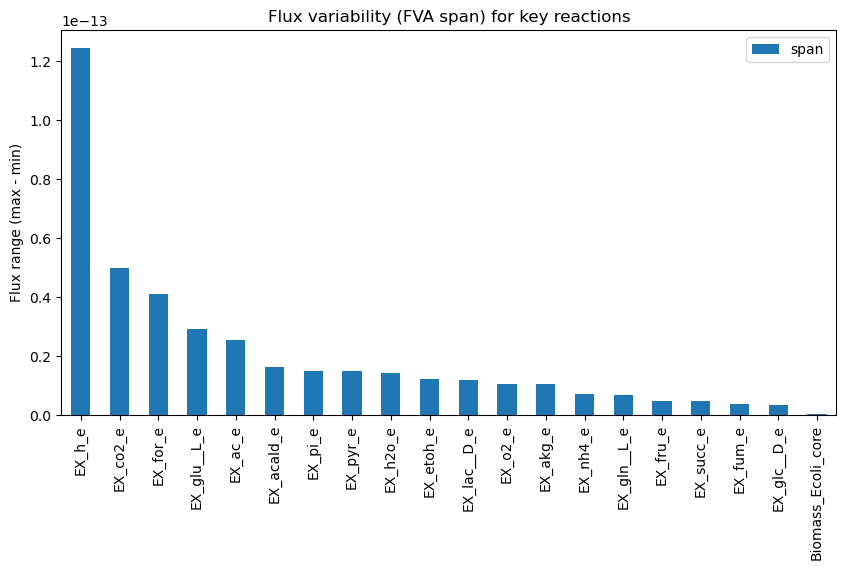

In [115]:
fva_df.head(20).plot(kind="bar", y="span", figsize=(10,5))
plt.title("Flux variability (FVA span) for key reactions")
plt.ylabel("Flux range (max - min)")
plt.savefig("results/image_1_FVA.png", dpi=300, bbox_inches="tight")
plt.show()